
<h1>Pre-Trained Natural Language Processing for Sentiment Analysis of Product Reviews</h1>

<h3>Description: Application project Prototype Assignment Notes</h3>
<h3>Completed Project Notes are included in pdf format in the folder</h3>

**Data and Algorithms that I will use**</br>
My project relies on the use of two main types of machine learning models: specific pre-trained natural language processing models sourced from popular python packages and libraries and 
classification models studied in class which will be used to try and deduce the polarity of a review based on the outputs of the previous NLP models. Though the classification aspect of my project is still under development and not represented in this submission, the NLP models have been chosen and initialized. I am using a variety of models including the TextBlob package's PatterAnalyzer and NaiveBayes models, the VADER (valence aware dictionary for sentiment reasoning) model and RoBERTa (robustly optimized BERT pretraining approach), all of which are pretrained and therefore have not been trained on my data. Thus, I can also use the results of this project to determine how apt these models are at identifying the polarity of customer product reviews based on the percentage accuracy of their results, and perhaps use this information to determine whether any one of them is particularly succesful at this task. In terms of classification models, I am currently planning to implement a linear classifier, support vector machine, and potentially an ensemble. The data I use is a csv file containing over 28 000 amazon customer reviews along with associated metadata such as submission time, product url, brand which I do not utilize (as I am only interested in the review text and rating out of 5).

**Outcomes I aim to achieve**</br>
I aim to ascertain which of these natural language processing models is best suited to deducing the polarity of customer reviews, as well as whether they can use in conjunction with a classifier to accurately determine the polarity and ratings of other reviews. The first objective would involve testing the accuracy rates of these different models for a large amount of sample data and calculating and visualizing the result of this experiment. Then, we can train a classifier model on the NLP outputs and attributed review polarities, then test it on some unseen reviews in order to determine whether the NLP models used can approximate the star rating of a given review with any reasonable degree of accuracy. We can also take the "mean" of the different NLP outputs to determine whether they more accurately reflect the actual polarity of reviews than the individual models do themselves. I aim to answer all of these questions through repeated testing and the plentiful use of supporting data to form and support my conclusions once they have been more fully established.

**How I will document my efforts and results**</br>
I will document my results through a mix of numerical data output describing the performance and characteristics of each model (accuracy rates, runtime, bias towards certain outputs) and
visualizations that will more effectively convey to a wider audience how the contrasting performance of different models can be cause for concern, as well as how the interpretation of
a given text input can vary widely from model to model. I will display summary statistics using a variety of charts and graphs in matplotlib, and will also employ visualization from other additional libraries such as wordcloud which I have found helpful when working on NLP projects. I have currently integrated bar charts demonstrating the respective sentiment distributions of the original data and the output of each of the models I used, and have used wordclouds to illustrate which words most commonly appear in reviews with positive,negative and neutral sentiments. I will add code to write both these visualizations and other numerical results to associated .txt files so that they can be easily submitted with my final project once it is complete.



<h3>Status: Done So Far</h3>
I have so far accomplished part of what I set forward to do when setting out my project plan, and have planned out what I still need to accomplish over the course of the next two weeks. Rather than web scrape for product reviews as I had initially planned, I decided to use a csv of Amazon customer reviews obtained from Kaggle. I loaded the data (keeping only the relevant review text and the assigned star rating), and created a new column for review sentiment, which I assigned to be negative for 1/2 star reviews and positive for 4/5 star reviews. Then, I spent some time researching several NLP models in order to identify some pretrained models I could test and use, finally settling on TextBlob's Pattern Analyzer and Naive Bayes Analyzer, VADER's sentiment intensity analyzer and Huggingface's RoBERTa Transformer model. After processing the review text to remove unwanted punctuation, simplify it and cap its length, I used it as an input to each of these models and saved the outputs in our original dataframe. Once I had outputs for all four models, I created visualizations using Matplotlib and TextBlob to compare the results of the different models. Currently, the outputs differ greatly between models, so I am working to ensure everything is correctly implemented and working as desired before I begin to draw conclusions regarding individual model effectiveness and accuracy rates.

<h3>Status: To Do</h3>
I still wish to create more visualizations to explore how my different pre-trained models differ in effectiveness, as well as calculate their different accuracies in order to determine whether one is better suited to the evaluation of such reviews. Evidently, I cannot expect the highest accuracy levels since these models are by definition pre-trained and unfamiliar with this specific dataset, but I am curious to ascertain whether any have an outsize advantage when working woth customer review data. I may also add more models for added data and comparison, and will potentially use a series of classifiers trained using the outputs of my NLP models to investigate whether I can accurately determine the star rating of a customer review based on the sentiments assigned to it by the aforementioned models. 

In [47]:
import matplotlib.pyplot as plt
import re 
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
from textblob import TextBlob 
from textblob.sentiments import NaiveBayesAnalyzer
import string
from nltk.corpus import stopwords
n_words= set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud,STOPWORDS
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer() 
from textblob import Blobber

In [48]:
#define the local path of the file to import
pathe="AmazonReviews.csv"

#import the desired data file
def importer(path):
  df=pd.read_csv(path,delimiter=",")
  df2=pd.DataFrame().assign(Ratings=df['reviews.rating'],Text=df['reviews.text'])
  sample=df2[0:2000]
  print(sample.tail)
  return sample

In [49]:
#translates the "star" rating of a customer into a sentiment based on the assumption that
# 1 or 2 stars indicate negativity, 4 or 5 stars indicate positivity, 3 stars indicate neutrality (mix of good/bad)
def evaluateRating(rating):
  
  sentiment=""
  if (rating==1 or rating==2):
    sentiment="Negative"
  elif(rating==4 or rating==5):
    sentiment="Positive"
  elif(rating==3):
    sentiment="Neutral"

  return sentiment

In [50]:
#this function serves to simplify reviews by limiting their length, removing unnescessary punctuation and numbers and ensuring that the
#remaining text can be aptly intepreted and processed by the models being used
#this cleaning is essential to prevent errors when running the pretrained NLP models
def clean(text):

  # removes @ tags, links and other miscellaneous punctuation from the text
  text= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split()) 
  # converts all letters used in the reviews to lower case and replaces dashes - with spaces
  text= text.lower().replace('-', ' ')
  # remves numbers and punctuation
  table= str.maketrans('', '', string.punctuation+string.digits)
  text= text.translate(table)
  
  return text[:500]

In [51]:
#this function uses the TextBlob Natural Language Processing Library, which can be used to calculate
#the subjectivity and polarity of a given text input
#based on the calculated polarity, one of three potential labels (NEG/POS/NEU) is assigned to the
#corresponding text input in the summary dataframe
def PatternAnalyzer(text):
  analysis=TextBlob(text)   #calculates sentiment/polarity of input text
  senti=analysis.sentiment.polarity   

  if senti<0:
    emotion="Negative"
  elif senti>0:
    emotion="Positive"
  else:
    emotion="Neutral"

  return emotion      #returns an associated "emotion" label based on polarity score

In [52]:
#instantiates an instance of the NaiveBayesAnalyser model from the TextBlob library
#were this not done outside the function, it would lead to greatly increased program runtime due to the need to repeatedly load the model
tb = Blobber(analyzer=NaiveBayesAnalyzer())

#this simple function calculates the probability of a given input text having either a positive/negative sentiment
#the sentiment with the highest probability is chosen and saved in the summary dataframe
def NaiveBayesAnalysis(text):
  analysis=tb(text)
  senti=analysis.sentiment[0]
  #print(analysis)
  #print(senti)
  if(senti=='pos'):
    return "Positive"
  elif(senti=="neg"):
    return "Negative"

In [53]:
# the valence aware dictionary for sentiment reasoning (VADER) is a widely used sentiment analyzer
#VADER analyzes the lexical features of an input text to return the probability of it being poistive, negative or neutral
#the output of the model is saved to the summary dataframe
def VaderAnalysis(text):
  analysis=SentimentIntensityAnalyzer()
  vs=analysis.polarity_scores(text)

  maxP=0
  sentiment=""
  for key,value in vs.items():
    if(key!="compound"):
      if value>maxP:
        maxP=value
        sentiment=key
  
    if sentiment=='neg':
      return 'Negative'
    elif sentiment=='pos':
      return 'Positive'
    elif sentiment=='neu':
      return 'Neutral'
  
  #return 

In [54]:
#RoBERTa (robustly optimized BERT pretraining approach) is a pretrained variation of the BERT
#(Bidirectional Representation for Transformers) model, a state of the art natural language processing
#model first proposed in 2018 and heavily developed by both industry and academics since then

#this initializes the RoBERTa model a single time to reduce runtime
roberta="cardiffnlp/twitter-roberta-base-sentiment"
rmodel = AutoModelForSequenceClassification.from_pretrained(roberta)
rtokenizer = AutoTokenizer.from_pretrained(roberta)

#this function analyzes the cleaned text input and calculates the probability of it being either
#positive/negative/neutral.first the text is broken into smaller pieces, then encoded and processed.
#Then, the respective probabilities are returned and the most probable sentiment is returned
def RobertaAnalysis(text):
  labels = ['Negative', 'Neutral', 'Positive']
  
  output=rmodel(**rtokenizer(text, return_tensors='pt'))
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  maxP=0
  sentiment=""
  for i in range(len(scores)):
    
    l = labels[i]
    s = scores[i]
    if (s>maxP):
      maxP=s
      sentiment=l
    #print(l,s)

  return sentiment

In [55]:
#this function sums the number of times the strings "positive", "negative" and "neutral" appear in a column and returns a bar chart displaying these values
#since we have standardized the outputs of each model to be one of these three words, this allows us to easily visualize and compare model performance
def plotSentiments(df,title):

  positive=df.str.contains("Positive").sum()
  #print(positive)
  negative=df.str.contains("Negative").sum()
  #print(negative)
  neutral=df.str.contains("Neutral").sum()
  #print(neutral)

  fig=plt.figure(figsize=(10,10))
  plt.bar(["positive","negative","neutral"],[positive,negative,neutral])
  plt.title(title)
  plt.show()

In [56]:
#this function serves to create custom "wordcloud" visualizations of the words which most commonly appear in negative (1/2 star), neutral (3 star) and positive (4/5 star) reviews
#these wordclouds are based on our own assignment of sentiments to reviews based on their star rating (rather than on the output of any of the respective models)
#this is an effective visualization for understanding what words might influence the final assigned sentiment of each review
#we maintain a list of stopwords to prevent commonly occuring words from being shown
def sentiment_wordclouds(sentimentTable,textTable):

  POStext=""
  NEGtext=""
  NEUtext=""

  j=0
  for x in sentimentTable:

    if x=="Positive":
      POStext+=textTable[j]
    
    if x=="Negative":
      NEGtext+=textTable[j]

    if x=="Neutral":
      NEUtext+=textTable[j]

    j+=1

  textlist=[POStext,NEGtext,NEUtext]
  titlelist=["positive","negative","neutral"]
  stop_words=["batteries","amazon","battery","candles","duracell","camera","amazonbasics"]+list(STOPWORDS)

  for i in range(len(textlist)):

    wordcloud=WordCloud(collocations=False,background_color="white",
                          width=1200, height=1000,stopwords=stop_words).generate(textlist[i])
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Wordcloud for "+titlelist[i])
    #plt.savefig(titlelist[i]+" wordcloud.png")
    plt.show() 

In [57]:
#imports relevant scikit-learn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

#this function divides the review sentiment data into two classes (Negative and Positive/Neutral) then does the same for the outputs of the NLP models used previously
#it then calculates the accuracy and precision of each model and prints this data for comparison purposes
def measurePerformance(df):

  #selects the class Negative or Positive/Neutral (these two are grouped together since some models do not output neutral polarities)
  y=df.iloc[0:,3].values      
  y=np.where(y=="Negative",0,1)

  #extracts polarity data ouput by the PatternAnalyzer, NaiveBayes, VADER and RoBERTa NLP models
  X=df.iloc[0:, [4,5,6,7]].values
  X=np.where(X=="Negative",0,1)

  X=X[1:]
  y=y[1:]

  patternAnalyzer=X[0:,0]
  naiveBayes=X[0:,1]
  vader=X[0:,2]
  roBERTa=X[0:,3]
  
  #prints accuracy and precision of various NLP models used to analyze the review data
  print("Pattern Analyzer accuracy: "+str(accuracy_score(y,patternAnalyzer)))
  print("Pattern Analyzer precision: "+str(precision_score(y,patternAnalyzer))+"\n")

  print("Naive Bayes accuracy: "+str(accuracy_score(y,naiveBayes)))
  print("Naive Bayes precision: "+str(precision_score(y,naiveBayes))+"\n")

  print("VADER accuracy: "+str(accuracy_score(y,vader)))
  print("VADER precision: "+str(precision_score(y,vader))+"\n")

  print("RoBERTa accuracy: "+str(accuracy_score(y,roBERTa)))
  print("RoBERTa precision: "+str(precision_score(y,roBERTa))+"\n")

  return y,X

In [58]:
#this function uses the binary polarity data output by the measurePerformance function to classify customer reviews according to whether they are positive or negative
#the classifier models used to do so are ..., as well as a VotingClassifier ensemble
#all classifiers demonstrate a relatively high accuracy rate of over 0.91, which is significantly higher than the average accuracy of the four NLP models used
def classifier(y,X):

  X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

  pipe1 = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=100, C=1.0, random_state=1))

  pipe2 = make_pipeline(DecisionTreeClassifier(max_depth=10,
                                             criterion='entropy',
                                             random_state=1))

  pipe3 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=20,
                                                             p=3,
                                                             metric='minkowski'))

  pipe4 = make_pipeline(StandardScaler(),LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr'))

  pipe5 = make_pipeline(StandardScaler(),RandomForestClassifier(criterion='entropy'))

  pipe6 = make_pipeline(StandardScaler(),SGDClassifier(loss='hinge'))

  clf_labels = ['Support Vector Machine', 'Decision tree', 'KNN','Logistic Regression','Random forest','SGD Classifier']
  
  print('10-fold cross validation:\n')
  for clf, label in zip([pipe1, pipe2, pipe3,pipe4,pipe5,pipe6], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print("Accuracy: " + str(round(scores.mean(), 2)) + 
          " Stdev: " + str(round(scores.std(), 3)) +
          " [" + label + "]")
  print("\n")
  from sklearn.ensemble import VotingClassifier

  mv_clf = VotingClassifier(estimators=[('svm', pipe1), ('dt', pipe2), ('kn', pipe3),('lrg',pipe4),('rdf',pipe5),('sgd',pipe6)])

  clf_labels += ['Majority voting']
  all_clf = [pipe1, pipe2, pipe3,pipe4,pipe5,pipe6, mv_clf]

  for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print("Accuracy: " + str(round(scores.mean(), 2)) + 
          " Stdev: " + str(round(scores.std(), 3)) +
          " [" + label + "]") 
          
  print("\n")
  pipe1.fit(X_train, y_train)

  y_pred = pipe1.predict(X_test)
  print(clf_labels[0])
  print('Misclassified test set examples:', (y_test != y_pred).sum())
  print('Out of a total of:', y_test.shape[0])
  print('Accuracy:', pipe1.score(X_test, y_test),"\n")


  pipe2.fit(X_train, y_train)

  y_pred = pipe2.predict(X_test)
  print(clf_labels[1])
  print('Misclassified test set examples:', (y_test != y_pred).sum())
  print('Out of a total of:', y_test.shape[0])
  print('Accuracy:', pipe2.score(X_test, y_test),"\n")


  pipe3.fit(X_train, y_train)

  y_pred = pipe3.predict(X_test)
  print(clf_labels[2])
  print('Misclassified test set examples:', (y_test != y_pred).sum())
  print('Out of a total of:', y_test.shape[0])
  print('Accuracy:', pipe3.score(X_test, y_test),"\n")


  pipe4.fit(X_train, y_train)

  y_pred = pipe4.predict(X_test)
  print(clf_labels[3])
  print('Misclassified test set examples:', (y_test != y_pred).sum())
  print('Out of a total of:', y_test.shape[0])
  print('Accuracy:', pipe4.score(X_test, y_test),"\n")


  pipe5.fit(X_train, y_train)

  y_pred = pipe5.predict(X_test)
  print(clf_labels[4])
  print('Misclassified test set examples:', (y_test != y_pred).sum())
  print('Out of a total of:', y_test.shape[0])
  print('Accuracy:', pipe5.score(X_test, y_test),"\n")


  pipe6.fit(X_train, y_train)

  y_pred = pipe6.predict(X_test)
  print(clf_labels[5])
  print('Misclassified test set examples:', (y_test != y_pred).sum())
  print('Out of a total of:', y_test.shape[0])
  print('Accuracy:', pipe6.score(X_test, y_test),"\n")


  mv_clf.fit(X_train, y_train)

  y_pred = mv_clf.predict(X_test)
  print("Majority Voting Ensemble")
  print('Misclassified test set examples:', (y_test != y_pred).sum())
  print('Out of a total of:', y_test.shape[0])
  print('Accuracy:', mv_clf.score(X_test, y_test),"\n")

<bound method NDFrame.tail of       Ratings                                               Text
0           3  I order 3 of them and one of the item is bad q...
1           4  Bulk is always the less expensive way to go fo...
2           5  Well they are not Duracell but for the price i...
3           5  Seem to work as well as name brand batteries a...
4           5  These batteries are very long lasting the pric...
...       ...                                                ...
1995        5                                      Good product.
1996        5                      Good product. Got it quickly.
1997        5          good product. my nephew love his present.
1998        5                                      good purchase
1999        5                                    Good Purchase !

[2000 rows x 2 columns]>


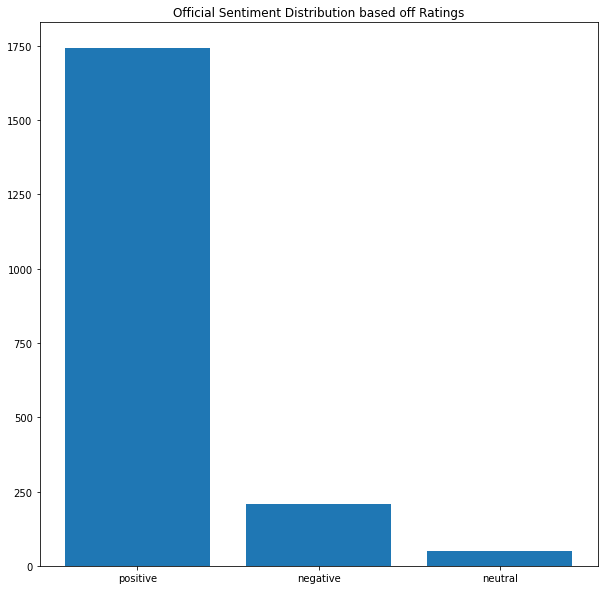

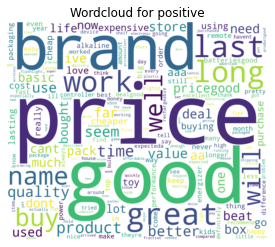

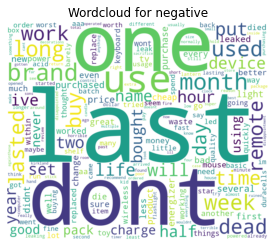

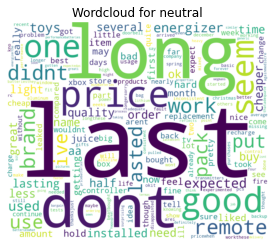

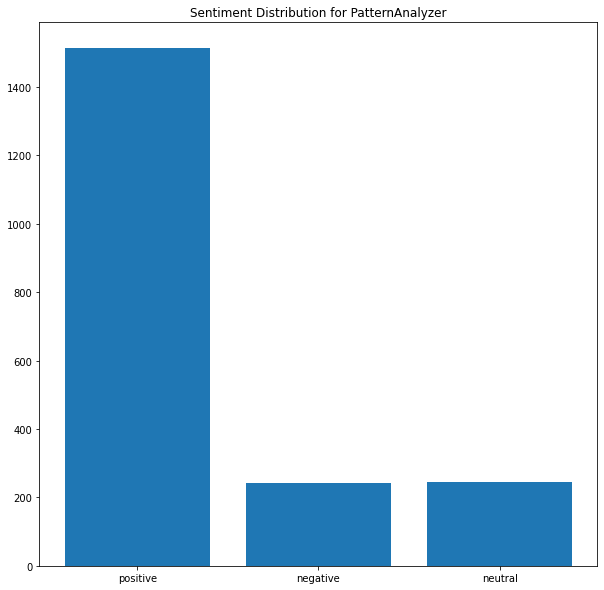

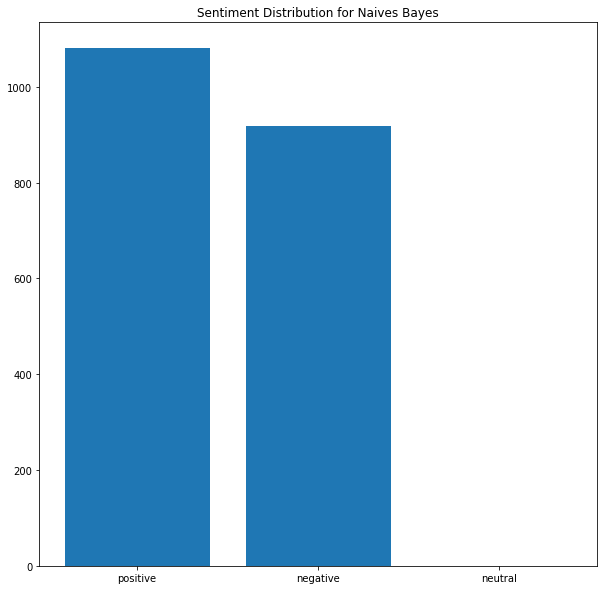

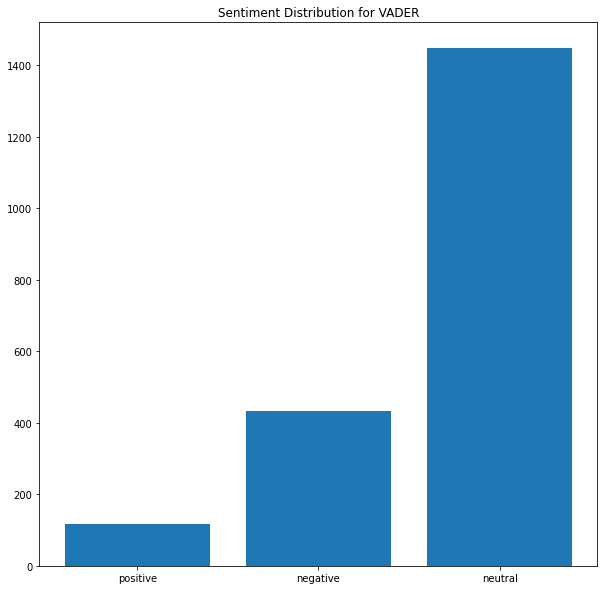

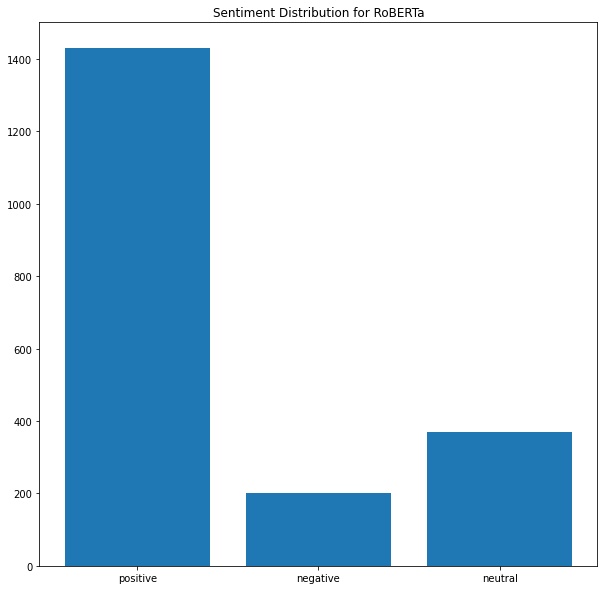

Pattern Analyzer accuracy: 0.8754377188594297
Pattern Analyzer precision: 0.938601478112564

Naive Bayes accuracy: 0.5712856428214107
Naive Bayes precision: 0.9324699352451434

VADER accuracy: 0.8339169584792396
VADER precision: 0.9661558109833972

RoBERTa accuracy: 0.9529764882441221
RoBERTa precision: 0.9716666666666667

10-fold cross validation:

Accuracy: 0.95 Stdev: 0.015 [Support Vector Machine]
Accuracy: 0.96 Stdev: 0.013 [Decision tree]
Accuracy: 0.96 Stdev: 0.013 [KNN]
Accuracy: 0.95 Stdev: 0.015 [Logistic Regression]
Accuracy: 0.95 Stdev: 0.016 [Random forest]
Accuracy: 0.94 Stdev: 0.021 [SGD Classifier]


Accuracy: 0.95 Stdev: 0.015 [Support Vector Machine]
Accuracy: 0.96 Stdev: 0.013 [Decision tree]
Accuracy: 0.96 Stdev: 0.013 [KNN]
Accuracy: 0.95 Stdev: 0.015 [Logistic Regression]
Accuracy: 0.95 Stdev: 0.015 [Random forest]
Accuracy: 0.95 Stdev: 0.018 [SGD Classifier]
Accuracy: 0.96 Stdev: 0.013 [Majority voting]


Support Vector Machine
Misclassified test set examples: 32

In [59]:
def main(path):

    #imports and loads a sample of the dataset for testing while project is under development
    df=importer(path)

    #cleans the customer reviews so that there are more easily intepretable by the models
    df['cleaned']=df['Text'].apply(lambda x: clean(x))

    #summarizes the number of positive/negative/neutral reviews and creates a corresponding bar chart
    df['Sentiment']=df['Ratings'].apply(lambda x: evaluateRating(x))
    plotSentiments(df['Sentiment'],"Official Sentiment Distribution based off Ratings")
    sentiment_wordclouds(df['Sentiment'],df['cleaned'])

    #runs the pattern analyzer model on the cleaned reviews and creates a corresponding bar chart
    df['PatternAnalyzer']=df['cleaned'].apply(lambda x: PatternAnalyzer(x))
    plotSentiments(df['PatternAnalyzer'],"Sentiment Distribution for PatternAnalyzer")

    #runs the Naive Bayes model on the cleaned reviews and creates a corresponding bar chart
    df['NaiveBayes']=df['cleaned'].apply(lambda x: NaiveBayesAnalysis(x))
    plotSentiments(df['NaiveBayes'],"Sentiment Distribution for Naives Bayes")

    #runs the VADER model on the cleaned reviews and creates a corresponding bar chart
    df['Vader']=df['cleaned'].apply(lambda x: VaderAnalysis(x))
    plotSentiments(df['Vader'],"Sentiment Distribution for VADER")

    #runs the RoBERTa model on the cleaned reviews and creates a corresponding bar chart
    df['Roberta']=df['cleaned'].apply(lambda x: RobertaAnalysis(x))
    plotSentiments(df['Roberta'],"Sentiment Distribution for RoBERTa")

    y,X=measurePerformance(df)
    classifier(y,X)



main(pathe)